# Beer Demand Prediction
## About data: 
Our customer is a large beverages producer. The file contains historical weekly sales quantity, 
sales value, price and promotion data for beer products (stock keeping units - SKUs) within 1 retail 
megastore for 7 years. 
* there are 98 different products (SKUs) 
* promotion data includes 3 types of in-store promotions: promo price, promo displays and 
catalogs. The promotions are expected to increase sales (but not guaranteed). The latter 2 
types also have different sub-types as defined in the dictionary 
* the raw data has been pre-processed so there is no need for data cleaning step 
* we also collected information on significant holiday events as the sales may 
increase/decrease on or around them   
## The goal: 
* come up with the best model for demand prediction (for sales quantity) 
## Additional information: 
* please provide preferred model for demand forecast for a subset of SKUs (5-10 of them, at 
your choice) 
* feel free to construct additional features from the variables provided if it helps 
* you don’t need to use all provided features 
* this is generally time series problem 
* ideally we would like to obtain also a measure of price elasticity (sensitivity of sales to a 
measure of price change) within the forecasting model 
* please send us the results as a Jupyter notebook or in your preferred format

In [1]:
!pip install openpyxl statsmodels xgboost

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

Let's take a look at the data:

In [3]:
df = pd.read_excel('./demo data.xlsx')
df.head()

,product,week_no,year,month,salesQ,price,revenue,promo_price,display_1,display_2,...,catalog_3,catalog_4,time.Halloween,time.Thanksgiving,time.Christmas,time.NewYear,time.Easter,time.Memorial,time.X4thJuly,time.LabourDay
0,beer.beer_SS1,1,1,Jan,22,5.450909,119.919998,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,beer.beer_SS1,2,1,Jan,12,6.450000,77.400000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,beer.beer_SS1,3,1,Jan,11,6.490000,71.390000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,beer.beer_SS1,4,1,Jan,4,6.490000,25.960000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,beer.beer_SS1,5,1,Feb,3,6.490000,19.470000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product            35672 non-null  object 
 1   week_no            35672 non-null  int64  
 2   year               35672 non-null  int64  
 3   month              35672 non-null  object 
 4   salesQ             35672 non-null  int64  
 5   price              35672 non-null  float64
 6   revenue            35672 non-null  float64
 7   promo_price        35672 non-null  int64  
 8   display_1          35672 non-null  int64  
 9   display_2          35672 non-null  int64  
 10  catalog_1          35672 non-null  int64  
 11  catalog_2          35672 non-null  int64  
 12  catalog_3          35672 non-null  int64  
 13  catalog_4          35672 non-null  int64  
 14  time.Halloween     35672 non-null  int64  
 15  time.Thanksgiving  35672 non-null  int64  
 16  time.Christmas     356

In [5]:
df.describe()

,week_no,year,salesQ,price,revenue,promo_price,display_1,display_2,catalog_1,catalog_2,catalog_3,catalog_4,time.Halloween,time.Thanksgiving,time.Christmas,time.NewYear,time.Easter,time.Memorial,time.X4thJuly,time.LabourDay
count,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.0,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000
mean,182.500000,3.991758,12.844724,7.720754,96.536907,0.286527,0.195307,0.065093,0.001822,0.085782,0.030556,0.0,0.019231,0.019231,0.016484,0.016484,0.019231,0.019231,0.019231,0.019231
std,105.078825,1.993820,15.773870,3.939364,141.137643,0.452145,0.396443,0.246693,0.042648,0.280045,0.172114,0.0,0.137337,0.137337,0.127327,0.127327,0.137337,0.137337,0.137337,0.137337
min,1.000000,1.000000,1.000000,0.990000,1.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,91.750000,2.000000,4.000000,4.990000,22.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,182.500000,4.000000,8.000000,7.070000,47.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,273.250000,6.000000,15.000000,10.990000,104.850000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,364.000000,7.000000,223.000000,30.990000,2697.969960,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we can see, catalog_4 consists of zeros; we can drop this column. Revenue = price * salesQ, so we can drop it too.

In [6]:
df.drop(columns=['catalog_4', 'revenue'], inplace=True)

We need to add month as a number:

In [7]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month_no'] = df['month'].map(months.index) + 1

Let's add some cyclical features:

In [8]:
df['m1'] = np.sin(df['month_no'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month_no'] * (2 * np.pi / 12))

I also want to add week number in a year; it may be relevant

In [9]:
df['week_of_year'] = (df['week_no'] - 1) % 52 + 1

I'll calculate sales for the last 10 weeks:

In [10]:
window = 10
for i in range(1, window + 1):
    df[f'sales_{i}'] = df.groupby('product').shift(i)['salesQ']

I'm also gonna add a 'price_change' column showing how price changed comparing to the previous week.

In [11]:
df['price_change'] = df['price'] - df.shift(1)['price']

In [12]:
df.head(15)

,product,week_no,year,month,salesQ,price,promo_price,display_1,display_2,catalog_1,...,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,price_change
0,beer.beer_SS1,1,1,Jan,22,5.450909,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,beer.beer_SS1,2,1,Jan,12,6.450000,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999091
2,beer.beer_SS1,3,1,Jan,11,6.490000,0,0,0,0,...,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.040000
3,beer.beer_SS1,4,1,Jan,4,6.490000,0,0,0,0,...,12.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,beer.beer_SS1,5,1,Feb,3,6.490000,0,0,0,0,...,11.0,12.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
5,beer.beer_SS1,6,1,Feb,11,6.090000,1,1,0,0,...,4.0,11.0,12.0,22.0,NaN,NaN,NaN,NaN,NaN,-0.400000
6,beer.beer_SS1,7,1,Feb,22,5.430000,1,1,0,0,...,3.0,4.0,11.0,12.0,22.0,NaN,NaN,NaN,NaN,-0.660000
7,beer.beer_SS1,8,1,Feb,25,6.230000,0,1,0,0,...,11.0,3.0,4.0,11.0,12.0,22.0,NaN,NaN,NaN,0.800000
8,beer.beer_SS1,9,1,Mar,4,5.990000,0,1,0,0,...,22.0,11.0,3.0,4.0,11.0,12.0,22.0,NaN,NaN,-0.240000
9,beer.beer_SS1,10,1,Mar,7,6.560000,0,0,0,0,...,25.0,22.0,11.0,3.0,4.0,11.0,12.0,22.0,NaN,0.570000


Let's check if all products have all data:

In [13]:
(df.groupby('product')['price'].count() == 364).all()

True

That's true, so every product has infomation for 364 weeks. Let's look at a few visualizations:

<AxesSubplot:title={'center':'Mean sales and price over time'}, xlabel='week_no'>

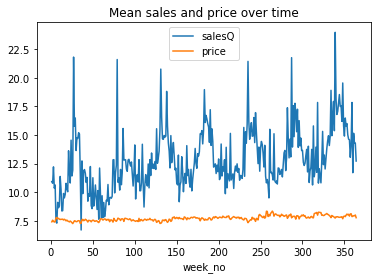

In [14]:
df.groupby(['week_no']).mean().plot(y=['salesQ', 'price'], title='Mean sales and price over time')

We can see a repeating pattern. Let's goup data by number of month and week in year:

<AxesSubplot:title={'center':'Sales and price dependency on the month'}, xlabel='month_no'>

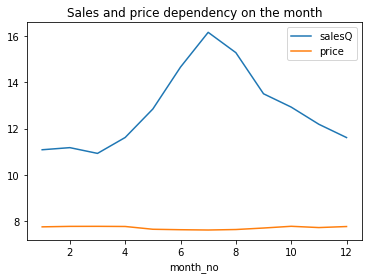

In [15]:
df.groupby(['month_no']).mean().plot(y=['salesQ', 'price'], title='Sales and price dependency on the month')

<AxesSubplot:title={'center':'Sales and price dependency on the week of year'}, xlabel='week_of_year'>

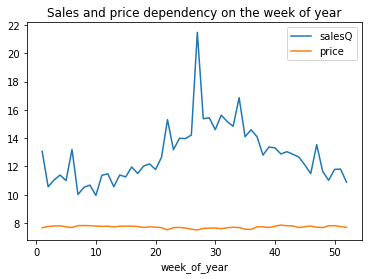

In [16]:
df.groupby('week_of_year').mean().plot(y=['salesQ', 'price'],  title='Sales and price dependency on the week of year')

There is an obvious pattern. Thus, month_no and week_of_year are important features.  
We can look at the difference of prices and sales of different SKUs:

<AxesSubplot:title={'center':'Product prices'}, xlabel='product'>

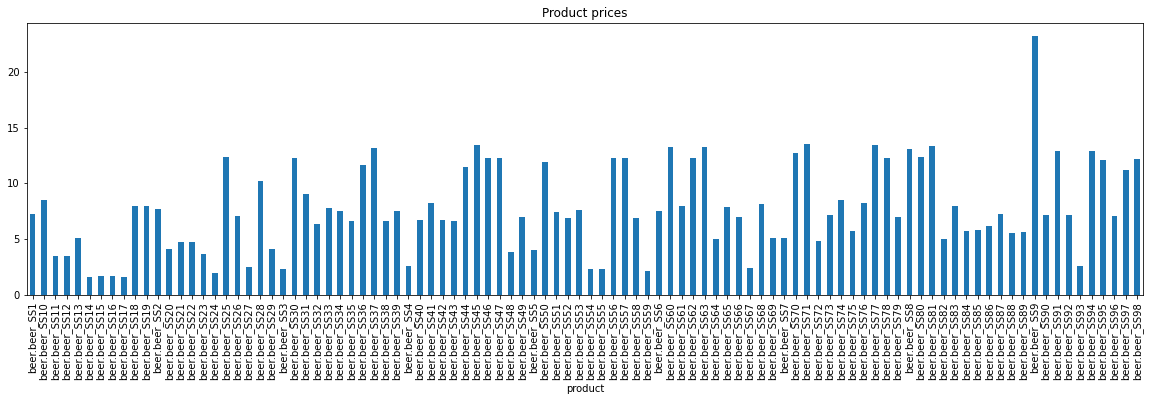

In [17]:
df.groupby('product')['price'].mean().plot(kind='bar', figsize=(20, 5), title='Product prices')

<AxesSubplot:title={'center':'Product sales'}, xlabel='product'>

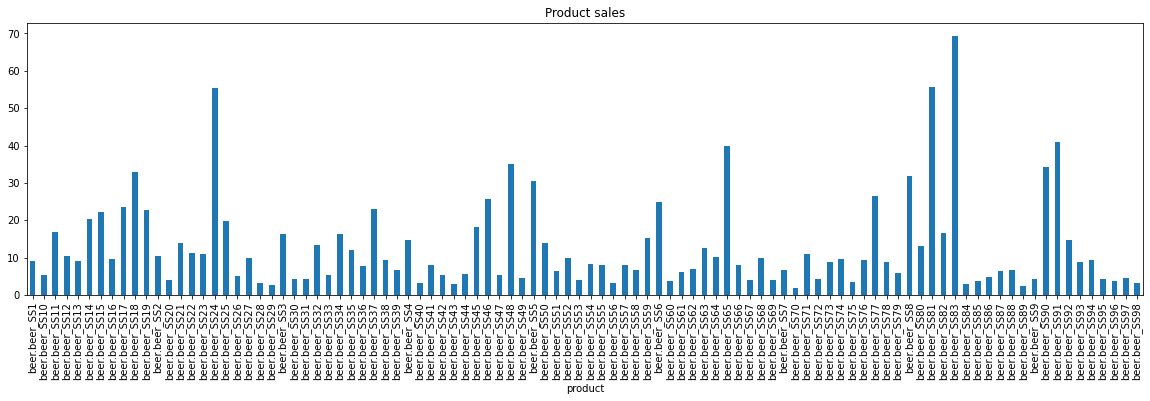

In [18]:
df.groupby('product')['salesQ'].mean().plot(kind='bar', figsize=(20, 5), title='Product sales')

Features Heatmap:

<AxesSubplot:>

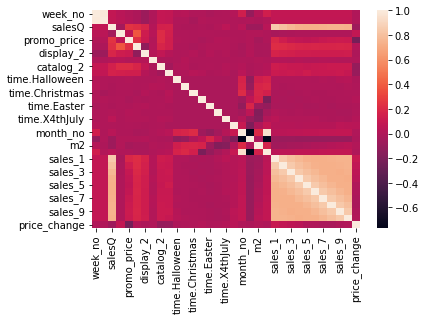

In [19]:
sns.heatmap(df.corr())

We need to put aside a subset of SKUs for the test.

In [20]:
test_products = df['product'].sample(10, random_state=1)
test_products

19947    beer.beer_SS55
619       beer.beer_SS2
4511     beer.beer_SS13
6591     beer.beer_SS19
1830      beer.beer_SS6
33691    beer.beer_SS93
26479    beer.beer_SS73
6926     beer.beer_SS20
26824    beer.beer_SS74
4115     beer.beer_SS12
Name: product, dtype: object

In [21]:
df_test = df[df['product'].isin(test_products)]
df_train = df[~df['product'].isin(test_products)]
len(df_train), len(df_test)

(32032, 3640)

In [22]:
df_train

,product,week_no,year,month,salesQ,price,promo_price,display_1,display_2,catalog_1,...,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,price_change
0,beer.beer_SS1,1,1,Jan,22,5.450909,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,beer.beer_SS1,2,1,Jan,12,6.450000,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999091
2,beer.beer_SS1,3,1,Jan,11,6.490000,0,0,0,0,...,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.040000
3,beer.beer_SS1,4,1,Jan,4,6.490000,0,0,0,0,...,12.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,beer.beer_SS1,5,1,Feb,3,6.490000,0,0,0,0,...,11.0,12.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35667,beer.beer_SS98,360,7,Nov,1,12.990000,0,0,0,0,...,3.0,4.0,2.0,3.0,2.0,2.0,1.0,1.0,3.0,-0.400000
35668,beer.beer_SS98,361,7,Nov,1,12.990000,0,0,0,0,...,2.0,3.0,4.0,2.0,3.0,2.0,2.0,1.0,1.0,0.000000
35669,beer.beer_SS98,362,7,Dec,3,12.990000,0,0,0,0,...,1.0,2.0,3.0,4.0,2.0,3.0,2.0,2.0,1.0,0.000000
35670,beer.beer_SS98,363,7,Dec,1,11.990000,1,0,0,0,...,1.0,1.0,2.0,3.0,4.0,2.0,3.0,2.0,2.0,-1.000000


I'll drop NaNs, as linear regression can't work with them; XGBoost, on the other hand, can

In [23]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [24]:
features = df_train.drop(columns=['product', 'month', 'salesQ', 'week_no', 'm1'])
targets = df_train['salesQ'].values

In [25]:
X_test, y_test = df_test.drop(columns=['product', 'salesQ', 'month', 'salesQ', 'week_no', 'm1']), df_test['salesQ'].values

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=1)

In [28]:
X_train.shape, X_val.shape

((24921, 30), (6231, 30))

Let's train a Linear Regression model:

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [30]:
lr = LinearRegression().fit(X_train, y_train)

In [31]:
y_pred = lr.predict(X_val)
mean_absolute_error(y_val, y_pred)

4.453948228285794

In [32]:
y_pred = lr.predict(X_test)
mean_absolute_error(y_test, y_pred)

3.9578856310416333

So there are results on the test set. We can visualize the most important features:

<AxesSubplot:title={'center':'Feature coefficients'}>

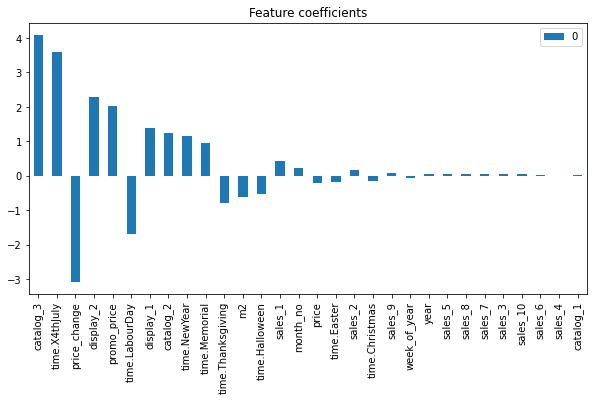

In [33]:
df_coeffs = pd.DataFrame(lr.coef_, lr.feature_names_in_).sort_values(by=0, key=abs, ascending=False)
df_coeffs.plot(kind='bar', figsize=(10, 5), title='Feature coefficients')

As we can see, the most important features are catalog_3, 4th July, price_change, display_2, promo_price and Labour Day; some of them raise demand and some reduce.   
Now we can calculate price elasticity with the formula: `Coefficient (Slope) * Price mean / Quantity mean`

In [34]:
slope = lr.coef_[1]
slope

-0.19379370577556626

In [35]:
mean_price = df_train.groupby('product')['price'].mean()
mean_price

product
beer.beer_SS1      7.323343
beer.beer_SS10     8.495437
beer.beer_SS11     3.507787
beer.beer_SS14     1.642392
beer.beer_SS15     1.683563
                    ...    
beer.beer_SS94    12.910228
beer.beer_SS95    12.125317
beer.beer_SS96     7.085574
beer.beer_SS97    11.216410
beer.beer_SS98    12.220423
Name: price, Length: 88, dtype: float64

In [36]:
mean_quantity = df_train.groupby('product')['salesQ'].mean()
mean_quantity

product
beer.beer_SS1      9.084746
beer.beer_SS10     5.432203
beer.beer_SS11    17.141243
beer.beer_SS14    20.587571
beer.beer_SS15    22.525424
                    ...    
beer.beer_SS94     9.502825
beer.beer_SS95     4.214689
beer.beer_SS96     3.686441
beer.beer_SS97     4.610169
beer.beer_SS98     3.183616
Name: salesQ, Length: 88, dtype: float64

In [37]:
price_elasticity = slope * mean_price / mean_quantity
price_elasticity

product
beer.beer_SS1    -0.156220
beer.beer_SS10   -0.303074
beer.beer_SS11   -0.039658
beer.beer_SS14   -0.015460
beer.beer_SS15   -0.014484
                    ...   
beer.beer_SS94   -0.263282
beer.beer_SS95   -0.557529
beer.beer_SS96   -0.372484
beer.beer_SS97   -0.471495
beer.beer_SS98   -0.743884
Length: 88, dtype: float64

<AxesSubplot:xlabel='product'>

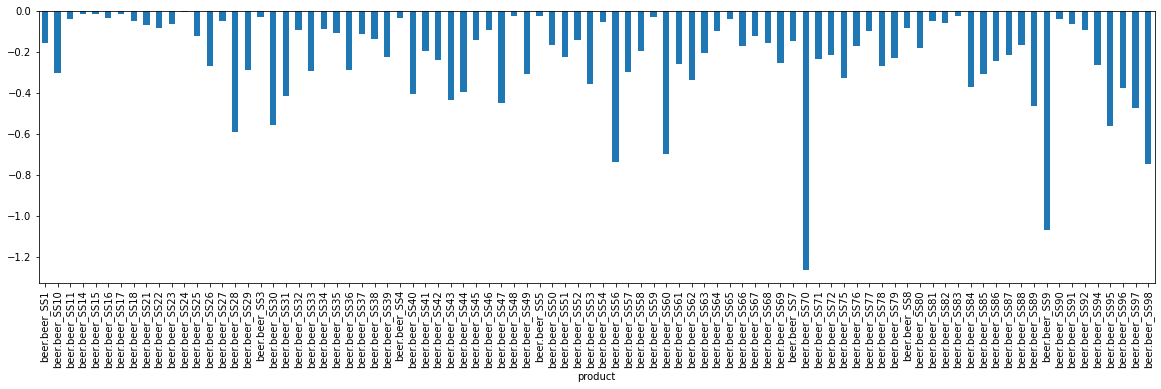

In [38]:
price_elasticity.plot(kind='bar', figsize=(20, 5))

In [39]:
price_elasticity.mean()

-0.23286050403244885

According to Wikipedia, Alcoholic beverages in US have elasticity about −0.3; sounds about right.   
Now I'd like to try XGBoost model

In [40]:
from xgboost import XGBRegressor, DMatrix, train

In [41]:
matrix_train = DMatrix(X_train, label=y_train)
matrix_val = DMatrix(X_val, label=y_val)
matrix_test = DMatrix(X_test)

In [42]:
model = train(params={'objective': 'reg:linear', 'eval_metric': ['mae', 'rmse']}, dtrain=matrix_train, num_boost_round=500, early_stopping_rounds=20, evals=[(matrix_val, 'val')])

[12:47:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	val-mae:8.94073	val-rmse:15.11393
[1]	val-mae:6.73091	val-rmse:11.80118
[2]	val-mae:5.43888	val-rmse:9.68033
[3]	val-mae:4.74005	val-rmse:8.37876
[4]	val-mae:4.38285	val-rmse:7.63566
[5]	val-mae:4.19668	val-rmse:7.16983
[6]	val-mae:4.10995	val-rmse:6.91205
[7]	val-mae:4.07640	val-rmse:6.80352
[8]	val-mae:4.04833	val-rmse:6.70479
[9]	val-mae:4.03126	val-rmse:6.64798
[10]	val-mae:4.01876	val-rmse:6.60174
[11]	val-mae:4.01192	val-rmse:6.57268
[12]	val-mae:4.00068	val-rmse:6.53652
[13]	val-mae:3.99816	val-rmse:6.52513
[14]	val-mae:3.98323	val-rmse:6.49744
[15]	val-mae:3.97607	val-rmse:6.48254
[16]	val-mae:3.96642	val-rmse:6.46192
[17]	val-mae:3.96925	val-rmse:6.46870
[18]	val-mae:3.95851	val-rmse:6.46243
[19]	val-mae:3.95717	val-rmse:6.45652
[20]	val-mae:3.95

In [43]:
y_pred = model.predict(matrix_test)

In [44]:
y_pred

array([ 8.369438 ,  5.6341796,  4.982959 , ..., 20.879164 , 22.074236 ,
       17.038345 ], dtype=float32)

In [45]:
y_test

array([ 5,  1, 10, ..., 17, 24,  9], dtype=int64)

In [46]:
mean_absolute_error(y_pred, y_test)

3.6521311751529995

Now we got a bit better result; it shows the advanages of the boosting model.